# Flood segmentation

### Importing libraries

In [1]:
# basic torch imports
import torch
from torchvision.transforms import ToTensor
import torch.nn as nn
import torch.nn.functional as F
# other important imports 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# albumentations and image handling
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader, Dataset , Subset, random_split
from PIL import Image

# utils
from src import utils

# misc imports
import time
import os

# adding parent directory to path
import sys
sys.path.append('..')

# Optimisation for training
from torch.cuda.amp import GradScaler, autocast

# Setting defaults for torch, seed and device
torch.manual_seed(42)
device =torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
# autoreload
%load_ext autoreload
%autoreload 2

### Creating the list of images

In [3]:
image_path = os.listdir(os.path.join('archive', 'Image'))
mask_path = os.listdir(os.path.join('archive', 'Mask'))
np.random.seed(42)
train_indices = np.random.choice(len(image_path), size=int(0.8*len(image_path)), replace=False)
test_indices = np.array(list(set(range(len(image_path))) - set(train_indices)))

### Splitting into training and testing

In [4]:
train_image_path = np.take(image_path, train_indices)
train_mask_path = np.take(mask_path, train_indices)
test_image_path = np.take(image_path, test_indices)
test_mask_path = np.take(mask_path, test_indices)


In [5]:
train_image = [Image.open(os.path.join('archive', 'Image', i)) for i in train_image_path]
train_mask = [Image.open(os.path.join('archive', 'Mask', i)) for i in train_mask_path]
test_image = [Image.open(os.path.join('archive', 'Image', i)) for i in test_image_path]
test_mask = [Image.open(os.path.join('archive', 'Mask', i)) for i in test_mask_path]

#### Changing to RGB

In [6]:
for i in range(len(train_image)):
    train_image[i] = train_image[i].convert('RGB')
for i in range(len(test_image)):
    test_image[i] = test_image[i].convert('RGB')

#### Setting transformations

In [7]:
# Transformations

Transforms = A.Compose([
    A.Resize(224,224),
    A.HorizontalFlip(p=0.75),
    A.VerticalFlip(p=0.75),
    # A.GridDistortion(p=0.75),
    A.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
    A.RandomBrightnessContrast(brightness_limit=0.4, contrast_limit=0.4, p=1),
    # A.PixelDropout(dropout_prob=0.5),
    # A.RandomShadow(shadow_roi=(0, 0.5, 1, 1), num_shadows_lower=1, num_shadows_upper=2, shadow_dimension=5, p=0.5),
    ToTensorV2(),
])

base = A.Compose([
    A.Resize(224, 224),
    A.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
    ToTensorV2(),
])
unnormailze = A.Compose([
    A.Normalize(
        mean=[0, 0, 0],
        std=[1/0.229, 1/0.224, 1/0.225],
    ),
    A.Normalize(
        mean=[-0.485, -0.456, -0.406],
        std=[1, 1, 1],
    ),
    ToTensorV2(),
])



### Custom Dataset to load the images and mask

In [9]:
train_dataset = utils.CustomFloodDataset(train_image, train_mask, transform=Transforms)
test_dataset = utils.CustomFloodDataset(test_image, test_mask, transform=base)

In [10]:
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)

### Initialising model

In [11]:

from src.vgg import VGG19UNet
Unet = VGG19UNet(num_classes=1).to(device)

In [12]:
optimizer = torch.optim.Adam(Unet.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()
es = utils.EarlyStopper(patience=50, verbose=True, model=Unet)

### Creating the random image

In [13]:
# empty list to store images
TO_GIF = []
# generate a random image to form into gif
random_idx = np.random.randint(0, len(test_image))
sample_image = ToTensor()(test_image[random_idx]).unsqueeze(0)
sample_image_transformed = Transforms(image=np.array(train_image[0]))['image'].unsqueeze(0).to(device)
scaler = GradScaler()

In [18]:
EPOCH = 200
PATIENCE = 20
es = utils.EarlyStopper(patience=PATIENCE, verbose=True,min_epoch=10, model = Unet)
import time
for epoch in range(EPOCH):
    train_loss = []
    Unet.train()

    # Training 
    t1 = time.time()
    for image, mask in train_dataloader:
        optimizer.zero_grad()
        with autocast():
            image = image.to(device)
            mask = mask.to(device)
            output = Unet(image).squeeze(1)
            loss = criterion(output.float(), mask.float())
        
        train_loss.append(loss.item())
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
    
    # Validation
    Unet.eval()
    test_loss = []
    with torch.no_grad():
        for image, mask in test_dataloader:
            with autocast():
                image = image.to(device)
                mask = mask.to(device)
                output = Unet(image).squeeze(1)
                loss = criterion(output.float(), mask.float())
            test_loss.append(loss.item())
        
        # Append to GIF
        sample_mask = Unet(sample_image_transformed)
        prob = F.sigmoid(sample_mask)
        predicted = (prob > 0.5).float()
        predicted = predicted.squeeze(0).squeeze(0).cpu().numpy()
        TO_GIF.append(predicted)
    
    t2 = time.time()
    if epoch % 1 == 0:
        print(f"Epoch: {epoch+1} / {EPOCH}, Loss: {np.mean(train_loss)}\t"
            f"Val Loss: {np.mean(test_loss)} \t Time: {t2-t1:.2f}")
    if es.early_stop(epoch, np.mean(test_loss)):
        TO_GIF = TO_GIF[:-PATIENCE]
        break
    

Epoch: 1 / 200, Loss: 0.6750393629074096	Val Loss: 0.5853976607322693 	 Time: 3.64
Epoch: 2 / 200, Loss: 0.6123062610626221	Val Loss: 0.5603480786085129 	 Time: 3.51
Epoch: 3 / 200, Loss: 0.49926122824350994	Val Loss: 0.4124305695295334 	 Time: 3.51
Epoch: 4 / 200, Loss: 0.4570421536763509	Val Loss: 0.34674006700515747 	 Time: 3.50
Epoch: 5 / 200, Loss: 0.41390158534049987	Val Loss: 0.3257076293230057 	 Time: 3.60
Epoch: 6 / 200, Loss: 0.3952710568904877	Val Loss: 0.3403831720352173 	 Time: 3.55
Epoch: 7 / 200, Loss: 0.38882330258687336	Val Loss: 0.3016233295202255 	 Time: 3.55
Epoch: 8 / 200, Loss: 0.37053970297177635	Val Loss: 0.3079864904284477 	 Time: 3.60
Epoch: 9 / 200, Loss: 0.3595964948336283	Val Loss: 0.29734601452946663 	 Time: 3.75
Epoch: 10 / 200, Loss: 0.34687459766864776	Val Loss: 0.2754177525639534 	 Time: 3.66
Epoch: 11 / 200, Loss: 0.34327858487764995	Val Loss: 0.2794342562556267 	 Time: 3.61
Epoch: 12 / 200, Loss: 0.3433804591496786	Val Loss: 0.27275435626506805 	 Tim

In [38]:
invTrans = A.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)

img_inv = invTrans(image=sample_image_transformed.squeeze(0).permute(1,2,0).cpu().numpy())

In [39]:
img_inv

{'image': array([[[0.48534507, 0.4563237 , 0.4066168 ],
         [0.48553988, 0.4563687 , 0.40665078],
         [0.48544994, 0.4562039 , 0.40656585],
         ...,
         [0.48564473, 0.4564436 , 0.40666774],
         [0.48552486, 0.4564436 , 0.4067017 ],
         [0.48499998, 0.456     , 0.40600002]],
 
        [[0.48499998, 0.456     , 0.40600002],
         [0.4850604 , 0.45600912, 0.4065149 ],
         [0.48527014, 0.45614395, 0.40663376],
         ...,
         [0.48499998, 0.456     , 0.40600002],
         [0.48499998, 0.456     , 0.40600002],
         [0.48499998, 0.456     , 0.40600002]],
 
        [[0.48499998, 0.456     , 0.40600002],
         [0.48499998, 0.456     , 0.40600002],
         [0.48499998, 0.456     , 0.40600002],
         ...,
         [0.48499998, 0.456     , 0.40600002],
         [0.48499998, 0.456     , 0.40600002],
         [0.48499998, 0.456     , 0.40600002]],
 
        ...,
 
        [[0.4850604 , 0.456     , 0.40600002],
         [0.48499998, 0.456     

In [19]:
EPOCH = 200
PATIENCE = 20
es = utils.EarlyStopper(patience=PATIENCE, verbose=True,min_epoch=10, model = Unet)
import time
for epoch in range(EPOCH):
    train_loss = []
    Unet.train()

    # Training 
    t1 = time.time()
    for image, mask in train_dataloader:
        optimizer.zero_grad()
        with autocast():
            image = image.to(device)
            mask = mask.to(device)
            output = Unet(image).squeeze(1)
            loss = criterion(output.float(), mask.float())
        
        train_loss.append(loss.item())
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
    
    # Validation
    Unet.eval()
    test_loss = []
    with torch.no_grad():
        for image, mask in test_dataloader:
            with autocast():
                image = image.to(device)
                mask = mask.to(device)
                output = Unet(image).squeeze(1)
                loss = criterion(output.float(), mask.float())
            test_loss.append(loss.item())
        
        # Append to GIF
        sample_mask = Unet(sample_image_transformed)
        prob = F.sigmoid(sample_mask)
        predicted = (prob > 0.5).float()
        predicted = predicted.squeeze(0).squeeze(0).cpu().numpy()
        TO_GIF.append(predicted)
    
    t2 = time.time()
    if epoch % 1 == 0:
        print(f"Epoch: {epoch+1} / {EPOCH}, Loss: {np.mean(train_loss)}\t"
            f"Val Loss: {np.mean(test_loss)} \t Time: {t2-t1:.2f}")
    if es.early_stop(epoch, np.mean(test_loss)):
        TO_GIF = TO_GIF[:-PATIENCE]
        break
    

Epoch: 1 / 200, Loss: 0.6508858760197958	Val Loss: 0.5329835936427116 	 Time: 6.93
Epoch: 2 / 200, Loss: 0.4857802371184031	Val Loss: 0.3694188967347145 	 Time: 3.70
Epoch: 3 / 200, Loss: 0.40237813790639243	Val Loss: 0.3102991431951523 	 Time: 3.56
Epoch: 4 / 200, Loss: 0.39627115925153095	Val Loss: 0.32283448427915573 	 Time: 3.51
Epoch: 5 / 200, Loss: 0.3848441700140635	Val Loss: 0.26000460237264633 	 Time: 3.53
Epoch: 6 / 200, Loss: 0.36365277171134947	Val Loss: 0.2553683966398239 	 Time: 3.42
Epoch: 7 / 200, Loss: 0.35519425868988036	Val Loss: 0.3706102967262268 	 Time: 3.40
Epoch: 8 / 200, Loss: 0.342207525173823	Val Loss: 0.2586507014930248 	 Time: 3.42
Epoch: 9 / 200, Loss: 0.3333087722460429	Val Loss: 0.2681273892521858 	 Time: 3.38
Epoch: 10 / 200, Loss: 0.3235733409722646	Val Loss: 0.2586708404123783 	 Time: 3.41
Epoch: 11 / 200, Loss: 0.3198519468307495	Val Loss: 0.2505151405930519 	 Time: 3.44
Epoch: 12 / 200, Loss: 0.3085319519042969	Val Loss: 0.26551777496933937 	 Time: 

In [20]:
es.load_best_model(Unet)

### Fine tuning

In [21]:
EPOCH = 100
PATIENCE = 10
for count, layer in enumerate(Unet.features):
    if count > 33:
        layer.requires_grad = True

es = utils.EarlyStopper(patience=PATIENCE, verbose=True,min_epoch=0, model = Unet)

optimizer = torch.optim.Adam(Unet.parameters(), lr=0.0001)
import time
for epoch in range(EPOCH):
    train_loss = []
    Unet.train()

    # Training 
    t1 = time.time()
    for image, mask in train_dataloader:
        optimizer.zero_grad()
        with autocast():
            image = image.to(device)
            mask = mask.to(device)
            output = Unet(image).squeeze(1)
            loss = criterion(output.float(), mask.float())
        
        train_loss.append(loss.item())
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
    
    # Validation
    Unet.eval()
    test_loss = []
    with torch.no_grad():
        for image, mask in test_dataloader:
            with autocast():
                image = image.to(device)
                mask = mask.to(device)
                output = Unet(image).squeeze(1)
                loss = criterion(output.float(), mask.float())
            test_loss.append(loss.item())
            # trying out print
        sample_mask = Unet(sample_image_transformed)
        prob = F.sigmoid(sample_mask)
        predicted = (prob > 0.5).float()
        predicted = predicted.squeeze(0).squeeze(0).cpu().numpy()
        TO_GIF.append(predicted)
    
    t2 = time.time()
    if epoch % 1 == 0:
        print(f"Epoch: {epoch+1} / {EPOCH}, Loss: {np.mean(train_loss)}\t"
            f"Val Loss: {np.mean(test_loss)} \t Time: {t2-t1:.2f}")
    if es.early_stop(epoch, np.mean(test_loss)):
        TO_GIF = TO_GIF[:-PATIENCE]
        break

Epoch: 1 / 100, Loss: 0.31854501167933147	Val Loss: 0.24878111109137535 	 Time: 3.70
Epoch: 2 / 100, Loss: 0.3119394421577454	Val Loss: 0.24620144441723824 	 Time: 3.47
Epoch: 3 / 100, Loss: 0.30403142670790356	Val Loss: 0.2439248524606228 	 Time: 3.47
Epoch: 4 / 100, Loss: 0.30021088719367983	Val Loss: 0.25474147126078606 	 Time: 3.50
Epoch: 5 / 100, Loss: 0.29874913990497587	Val Loss: 0.25121987611055374 	 Time: 3.49
Epoch: 6 / 100, Loss: 0.30352449615796406	Val Loss: 0.2564893327653408 	 Time: 3.47
Epoch: 7 / 100, Loss: 0.3064012944698334	Val Loss: 0.26936591789126396 	 Time: 3.53
Epoch: 8 / 100, Loss: 0.2993770678838094	Val Loss: 0.2592531554400921 	 Time: 3.49
Epoch: 9 / 100, Loss: 0.29746734897295635	Val Loss: 0.2619357034564018 	 Time: 3.58
Epoch: 10 / 100, Loss: 0.2955687165260315	Val Loss: 0.26806429773569107 	 Time: 3.55
Epoch: 11 / 100, Loss: 0.2962989677985509	Val Loss: 0.26416561007499695 	 Time: 3.52
Epoch: 12 / 100, Loss: 0.2964689870675405	Val Loss: 0.2679826393723488 	

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


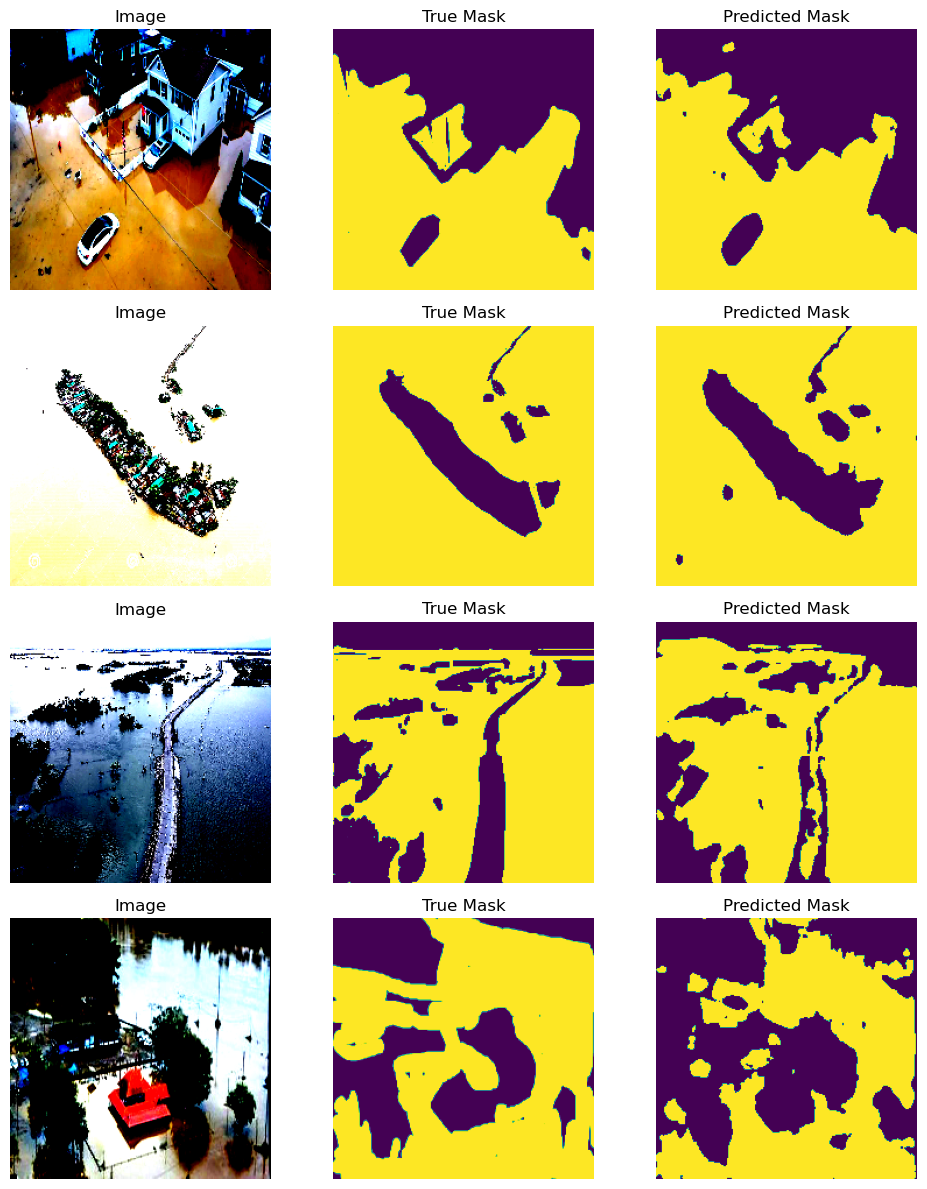

In [22]:
plot_number = 4
fig, ax = plt.subplots(plot_number,3,figsize=(10,plot_number*3))
Unet.eval()
test_mask = Unet(image.to(device))
prob = F.sigmoid(test_mask)
predicted = (prob > 0.5).float()
with torch.no_grad():
    for i in range(plot_number):
        ax[i,0].imshow(image[i].cpu().permute(1,2,0))
        ax[i,0].axis('off')
        ax[i,0].set_title('Image')
        ax[i,1].imshow(mask[i].squeeze(0).cpu().numpy())
        ax[i,1].axis('off')
        ax[i,1].set_title('True Mask')
        ax[i,2].imshow(predicted.cpu().detach().numpy()[i].squeeze(0))
        ax[i,2].axis('off')
        ax[i,2].set_title('Predicted Mask')
        fig.tight_layout()
plt.show()

In [23]:
TO_GIF = [(x*255).astype(np.uint8) for x in TO_GIF]

## Generate GIF

In [24]:
utils.create_gif(images = TO_GIF,
                sample_image = sample_image_transformed.squeeze(0).permute(1,2,0).cpu().numpy(), 
                 gif_name= 'sample_segmentation', 
                fps=3)

# END